In [169]:
# Packages
import psycopg2
from psycopg2 import OperationalError
from psycopg2 import sql

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import networkx as nx

from datetime import datetime, timedelta
from IPython.display import HTML

import os
from dotenv import load_dotenv
dotenv_path = os.path.expanduser('~/.pwds.env')
load_dotenv(dotenv_path)



# Conexão à base de dados
db_host = os.getenv('DB_HOST')
db_port = os.getenv('DB_PORT')
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')


conn = psycopg2.connect(
                host = db_host,
                port = db_port,
                user = db_user,
                password = db_password
        )

In [170]:
cur = conn.cursor()
cur.execute('''ROLLBACK;''')

In [171]:
def h(df):
    """
    Função que permite ver dataframe completa e de forma mais organizada
    """
    return HTML(df.to_html(index=False))

# Ramo 2

### Comparar número de contratos celebrados entre NIF1 e NIF2 com CPV_XXX

Sempre que é analisado um conjunto de contratos: 

1. Identificar contrato pelo ID
2. Identificar os 3 primeiros dígitos do CPV: categoria
3. Identificar o NIF da entidade adjudicante: NIF1
4. Identificar o NIF da entidade vencedora: NIF2
5. Calcular o número de contratos celebrados para a respetiva categoria: X
6. Calcular o número de contratos ganhos pela entidade com NIF2 para a mesma categoria identificada no ponto 2: Y
7. Calcular o rácio Y/X. Quanto mais próximo de 1, mais suspeito

In [183]:
def contracts(n,cpv):
    """
    Função que retorna os IDs referentes a uma determinada categoria de CPV

    Argumentos:
    n (int): número de dígitos a considerar no slice do CPV ( 2: menor granularidade | 8: muito específico)
    cpv (str): primeiros n dígitos do cpv. Número de dígitos tem de coincidir com n, caso contrário retorna sempre 0 

    return: (tuple) IDs
    """
    
    cur = conn.cursor()

    query = '''
            SELECT concursos_publicos."id", concursos_publicos."data_publicacao", SUBSTRING(concursos_publicos."cpv",1,%s), nif1, nif2, adjudicante, adjudicataria, contratos_basegov."preco_contratual"
            FROM concursos_publicos
            JOIN contratos_basegov ON concursos_publicos."id" = contratos_basegov."id"
            WHERE SUBSTRING(concursos_publicos."cpv",1,%s) = %s;
            '''
    cur.execute(query,(n,n,cpv,))
    result = cur.fetchall()

    return result

In [184]:
gas = contracts(3,'652')
agua = contracts(3,'651')
energia = contracts(3,'653')
travel = contracts(3,'635')
internet = contracts(3,'724')
op_system = contracts(4,'4862')

In [185]:
print(f"Número de contratos para gás: {len(gas)}")
print(f"Número de contratos para água: {len(agua)}")
print(f"Número de contratos para energia: {len(energia)}")
print(f"Número de contratos para viagens: {len(travel)}")
print(f"Número de contratos para internet: {len(internet)}")
print(f"Número de contratos para sistemas operativos: {len(op_system)}")

Número de contratos para gás: 71
Número de contratos para água: 66
Número de contratos para energia: 234
Número de contratos para viagens: 822
Número de contratos para internet: 149
Número de contratos para sistemas operativos: 23


In [186]:
def data_frame(*args):
    
    df = pd.DataFrame(columns=args)
    return df

energia_df = data_frame('id', 'data', 'nif1', 'nif1_nr', 'nif2', 'nif2_nr', 'nif12_nr', '%',    'adjudicante', 'vencedora', 'preco_contrato')
gas_df = data_frame('id', 'data', 'nif1', 'nif1_nr', 'nif2', 'nif2_nr', 'nif12_nr', '%',        'adjudicante', 'vencedora', 'preco_contrato')
agua_df = data_frame('id', 'data', 'nif1', 'nif1_nr', 'nif2', 'nif2_nr', 'nif12_nr', '%',       'adjudicante', 'vencedora', 'preco_contrato')
travel_df = data_frame('id', 'data', 'nif1', 'nif1_nr', 'nif2', 'nif2_nr', 'nif12_nr', '%',     'adjudicante', 'vencedora', 'preco_contrato')
internet_df = data_frame('id', 'data', 'nif1', 'nif1_nr', 'nif2', 'nif2_nr', 'nif12_nr', '%',   'adjudicante', 'vencedora', 'preco_contrato')
op_system_df = data_frame('id', 'data', 'nif1', 'nif1_nr', 'nif2', 'nif2_nr', 'nif12_nr', '%',  'adjudicante', 'vencedora', 'preco_contrato')

In [187]:
def contracts_number_nif12(dia,cpv,n,nif1,nif2,yearly):
    """
    Função que retorna o número de contratos ganhos por uma determinada entidade nos últimos 12 meses a partir de um determinado dia
    para uma categoria de contratos

    Argumentos:
    dia (date YYYY-MM-DD): data em que o contrato foi publicado no portal Base
    cpv (str): primeiros n dígitos do CPV 
    n (int): número de dígitos a considerar na categorização do CPV

    return (int): número de contratos celebrados 
    """

    if yearly == 'True':
        cur = conn.cursor()
        cur.execute('''
                    SELECT COUNT(*)
                    FROM concursos_publicos
                    WHERE SUBSTRING(concursos_publicos."cpv", 1, %s) = %s
                              AND concursos_publicos."nif1" = %s
                              AND concursos_publicos."nif2" = %s
                              AND concursos_publicos.data_publicacao >= %s - INTERVAL '12 months'
                              AND concursos_publicos.data_publicacao <= %s                
                    ;
                    ''', (n,cpv,nif1,nif2,dia,dia))
        
        return(cur.fetchone()[0])

    
    else:
        cur = conn.cursor()
        cur.execute('''
                    SELECT COUNT(*)
                    FROM concursos_publicos
                    WHERE SUBSTRING(concursos_publicos."cpv", 1, %s) = %s
                              AND concursos_publicos."nif1" = %s
                              AND concursos_publicos."nif2" = %s             
                    ;
                    ''', (n,cpv,nif1,nif2))
        
        return(cur.fetchone()[0])

In [188]:
def contracts_number_nif2(dia,cpv,n,nif,yearly):
    """
    Função que retorna o número de contratos ganhos por uma determinada entidade nos últimos 12 meses a partir de um determinado dia
    para uma categoria de contratos

    Argumentos:
    dia (date YYYY-MM-DD): data em que o contrato foi publicado no portal Base
    cpv (str): primeiros n dígitos do CPV 
    n (int): número de dígitos a considerar na categorização do CPV

    return (int): número de contratos celebrados 
    """

    if yearly == 'True':
        cur = conn.cursor()
        cur.execute('''
                    SELECT COUNT(*)
                    FROM concursos_publicos
                    WHERE SUBSTRING(concursos_publicos."cpv", 1, %s) = %s
                              AND concursos_publicos."nif2" = %s
                              AND concursos_publicos.data_publicacao >= %s - INTERVAL '12 months'
                              AND concursos_publicos.data_publicacao <= %s                
                    ;
                    ''', (n,cpv,nif,dia,dia))
            
        return(cur.fetchone()[0])

    else:
        cur = conn.cursor()
        cur.execute('''
                    SELECT COUNT(*)
                    FROM concursos_publicos
                    WHERE SUBSTRING(concursos_publicos."cpv", 1, %s) = %s
                              AND concursos_publicos."nif2" = %s      
                    ;
                    ''', (n,cpv,nif))
            
        return(cur.fetchone()[0])

In [189]:
def contracts_number_nif1(dia,cpv,n,nif,yearly):
    """
    Função que retorna o número de contratos ganhos por uma determinada entidade nos últimos 12 meses a partir de um determinado dia
    para uma categoria de contratos

    Argumentos:
    dia (date YYYY-MM-DD): data em que o contrato foi publicado no portal Base
    cpv (str): primeiros n dígitos do CPV 
    n (int): número de dígitos a considerar na categorização do CPV

    return (int): número de contratos celebrados 
    """

    if yearly == 'True':
        cur = conn.cursor()
        cur.execute('''
                    SELECT COUNT(*)
                    FROM concursos_publicos
                    WHERE SUBSTRING(concursos_publicos."cpv", 1, %s) = %s
                              AND concursos_publicos."nif1" = %s
                              AND concursos_publicos.data_publicacao >= %s - INTERVAL '12 months'
                              AND concursos_publicos.data_publicacao <= %s                
                    ;
                    ''', (n,cpv,nif,dia,dia))
        
        return(cur.fetchone()[0])

    else:
        cur = conn.cursor()
        cur.execute('''
                    SELECT COUNT(*)
                    FROM concursos_publicos
                    WHERE SUBSTRING(concursos_publicos."cpv", 1, %s) = %s
                              AND concursos_publicos."nif1" = %s            
                    ;
                    ''', (n,cpv,nif))
        
        return(cur.fetchone()[0])

In [53]:
#contracts_number(dia,cpv,n)
#contracts_number_nif2(dia,cpv,n,nif)

# x1         x2             x3                 x4   x5        x6            x7             x8
# id  data_publicacao  SUBSTRING(cpv,1,%s)   nif1  nif2   adjudicante  adjudicataria  preco contrato

#data_frame('id', 'data', 'nif2', 'nif2_nr', 'total_cpv', '%', 'entidade')

for i,j in enumerate(gas):

    x1,x2,x3,x4,x5,x6,x7,x8 = j
    
    # Número de dígitos considerado para categorização do CPV
    n = len(x3)



    #print(f"Número de contratos celebrados com CPV {x3} nos últimos 12 meses desde o dia {x2}: \t{nr_cpv}")

    nr_nif1 = contracts_number_nif1(x2,x3,n,x4, 'False')
    nr_nif2 = contracts_number_nif2(x2,x3,n,x5, 'False')
    nr_nif12 = contracts_number_nif12(x2,x3,n,x4,x5, 'False')

    r = round(nr_nif12/nr_nif1 * 100,1)
    gas_df.loc[i] = (x1,x2,x4,nr_nif1,x5,nr_nif2,nr_nif12,r,x6,x7,x8)

In [56]:
gas_df = gas_df.sort_values(by=['data'], ascending=[False])

h(gas_df)

id,data,nif1,nif1_nr,nif2,nif2_nr,nif12_nr,%,adjudicante,vencedora
10586009,2024-02-27,600038106,1,509828698,1,1,100.0,Serviços de Ação Social da Universidade de Coimbra,"Dourogás Natural - Medição e Explopração de Sistemas, S.A."
10551187,2024-02-09,505948605,4,507039440,6,2,50.0,Município de Guimarães,"Repsol Gás Portugal, Unipessoal, Lda"
10515466,2024-01-25,501205551,10,500697370,17,8,80.0,Município de Chaves,"Petrogal S.A. (Galp Energia, SGPS, S.A)"
10515498,2024-01-25,501205551,10,500697370,17,8,80.0,Município de Chaves,"Petrogal S.A. (Galp Energia, SGPS, S.A."
10515536,2024-01-25,501205551,10,500697370,17,8,80.0,Município de Chaves,"Petrogal, S.A. (Galp Energia, SGPS, S.A.)"
10443578,2024-01-09,507330609,4,500697370,17,3,75.0,Freguesia de Marvila,"PETROGAL, S.A."
10356128,2023-11-23,506803228,1,500266344,2,1,100.0,ATEC - Associação de Formação para a Indústria,"Linde Portugal, Lda."
10328792,2023-11-07,506197174,2,980393388,8,1,50.0,"MS - Matosinhos Sport - Empresa Municipal de Gestão e Equipamentos Desportivos e de Lazer, E. M.","Gás Natural Comercializadora, S.A. – Sucursal Em Portugal"
10285750,2023-10-11,513606084,2,500266344,2,1,50.0,"Águas do Norte, S. A.","Linde Portugal, Lda."
10105931,2023-07-04,501413197,1,500697370,17,1,100.0,Universidade do Porto,"Petrogal, S.A."


In [67]:
len(gas_df.iloc[:,2].unique())

42

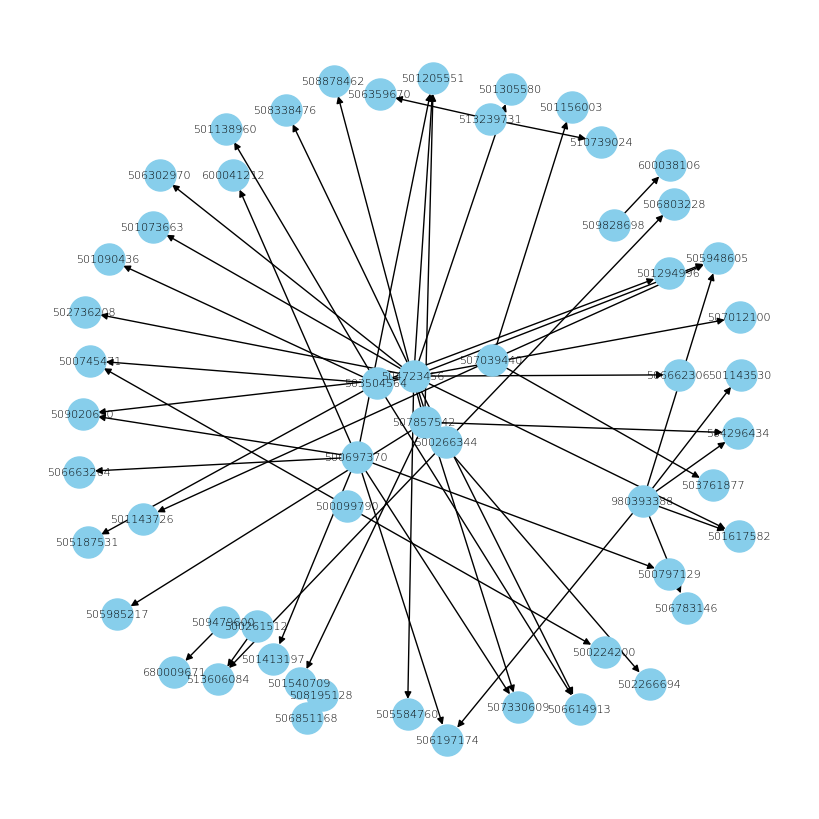

In [166]:
G = nx.DiGraph()

for _, row in gas_df.iterrows():
    G.add_edge(row['nif2'], row['nif1'])

# Draw the graph
plt.figure(figsize=(8, 8))
nx.draw(G, with_labels=True, node_size=500, node_color='skyblue', font_size=8, font_weight='light')
plt.show()

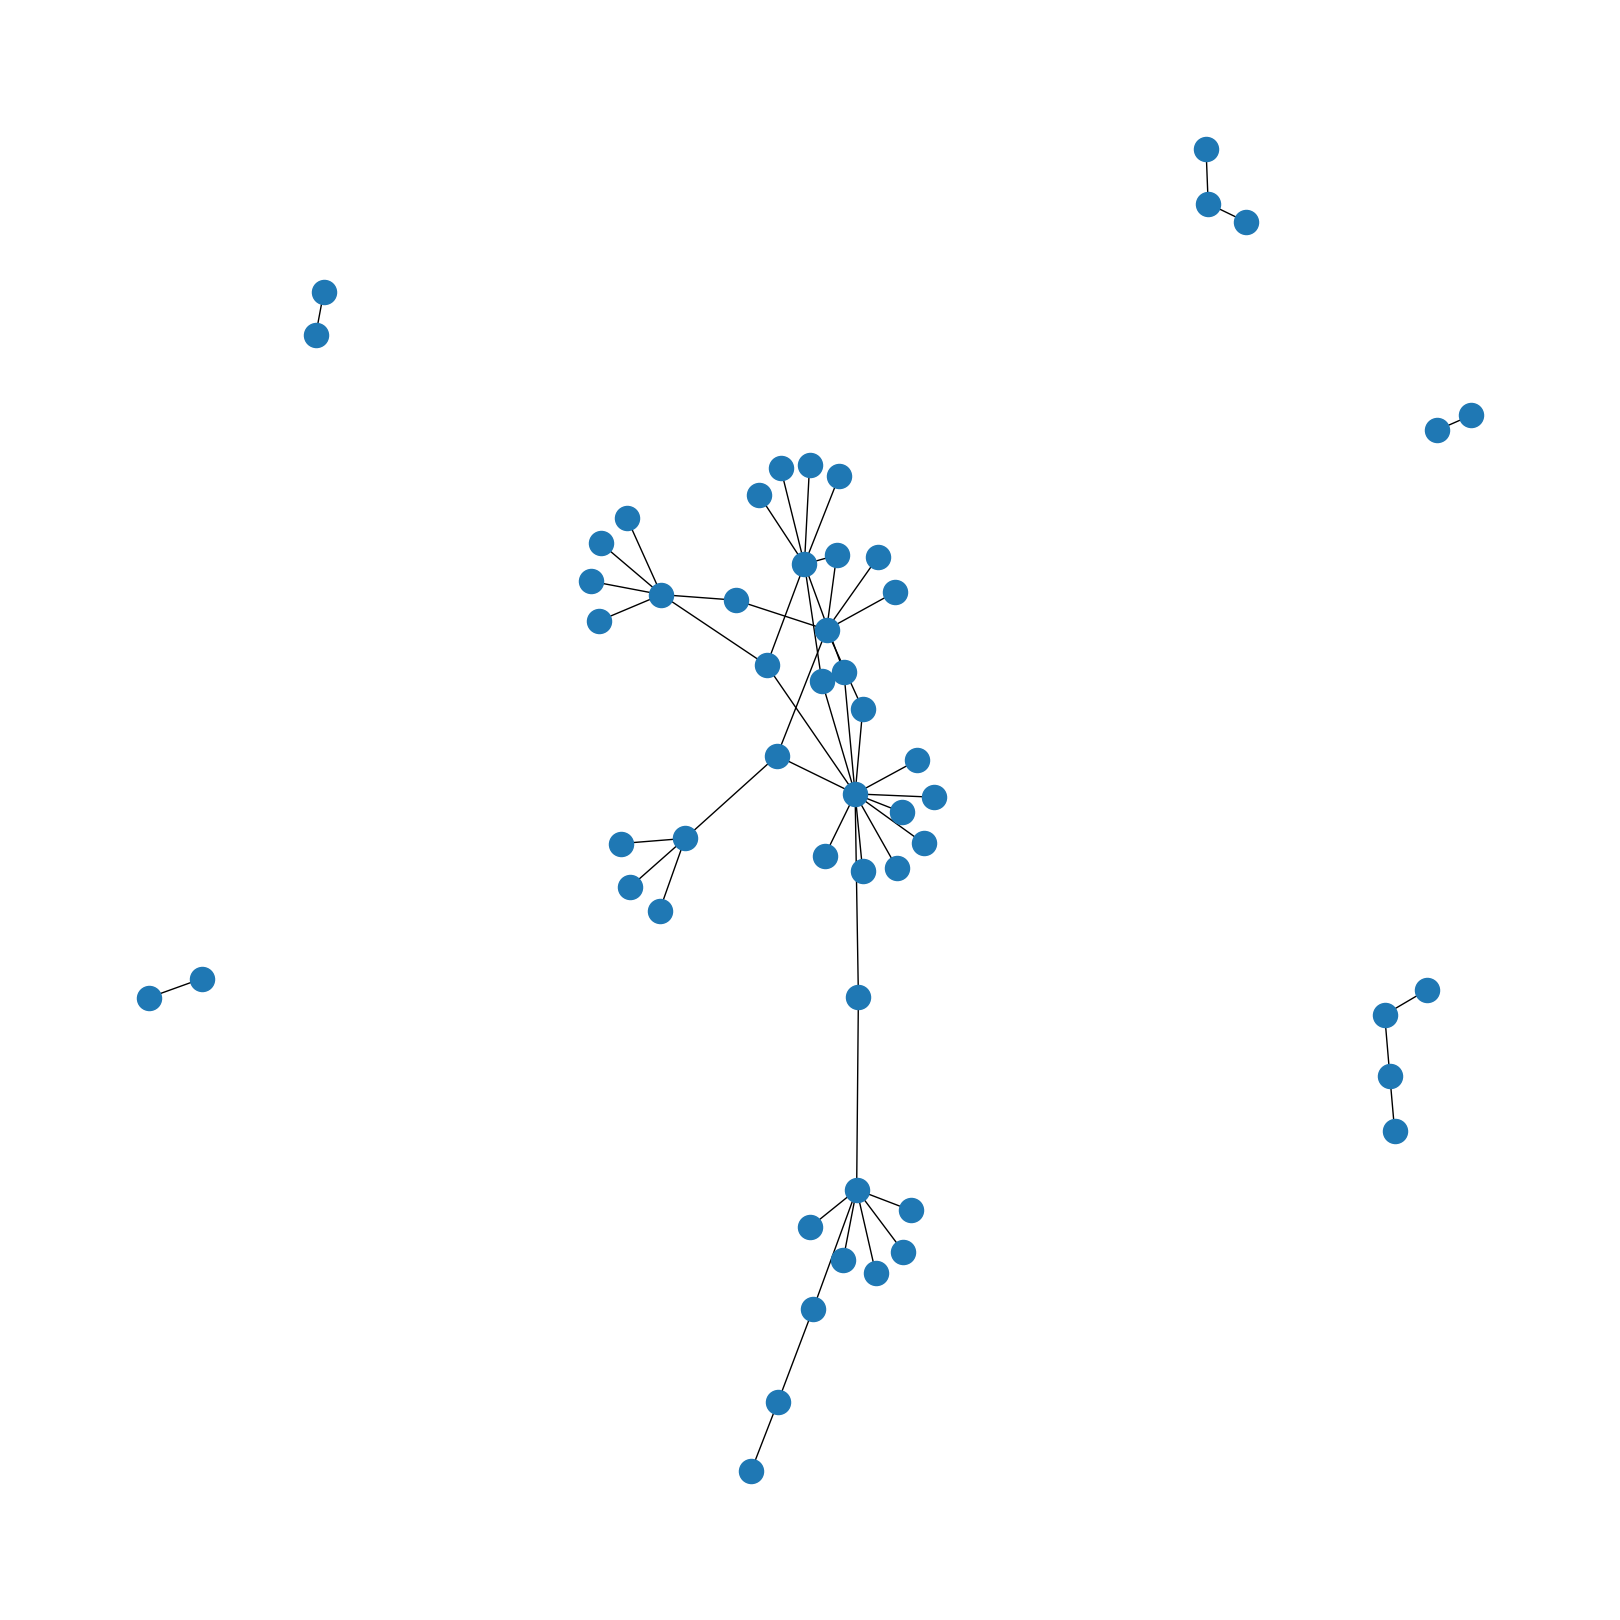

In [104]:
g = nx.from_pandas_edgelist(gas_df, source='nif2', target='nif1') 
nx.draw(g)

In [94]:
contratante = list(gas_df.nif1.unique())
vencedora = list(gas_df.nif2.unique())

dict(zip(contratante, vencedora))

{'600038106': '509828698',
 '505948605': '507039440',
 '501205551': '500697370',
 '507330609': '500266344',
 '506803228': '980393388',
 '506197174': '507857542',
 '513606084': '508195128',
 '501413197': '504723456',
 '504296434': '503504564',
 '501540709': '513239731',
 '501143530': '500099790',
 '508878462': '509479600',
 '506663264': '500261512'}

In [97]:
G.degree('505948605')

3

In [99]:
[G.degree(contrat) for contrat in contratante]

[1,
 3,
 3,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1]

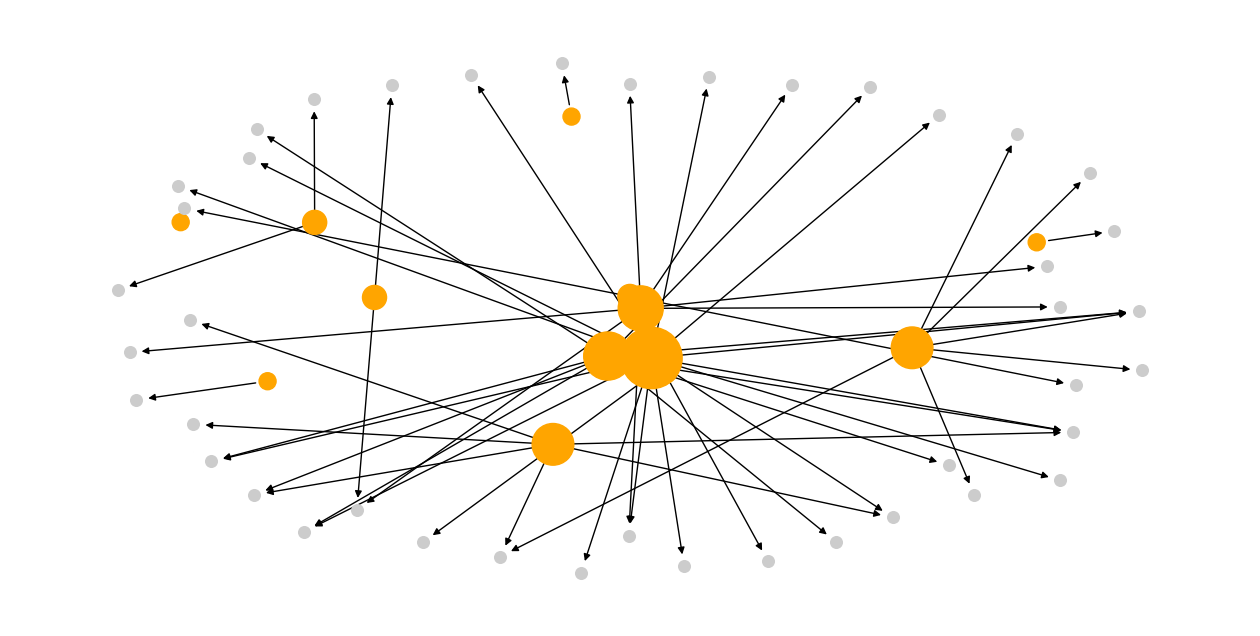

In [168]:
plt.figure(figsize=(16, 8))

contratante = list(gas_df.nif1.unique())
vencedora = list(gas_df.nif2.unique())

# 1. Create the graph
G = nx.from_pandas_edgelist(gas_df, source='nif2', target='nif1') 
G = nx.DiGraph()
for _, row in gas_df.iterrows():
    G.add_edge(row['nif2'], row['nif1'])


# 2. Create a layout for our nodes 
layout = nx.spring_layout(G,iterations=50)

# 3. Draw the parts we want

# Club = vencedora | NIF2

# Edges thin and grey
# People small and grey
# Clubs sized according to their number of connections
# Clubs blue
# Labels for clubs ONLY
# People who are highly connected are a highlighted color

# Go through every club name, ask the graph how many
# connections it has. Multiply that by 80 to get the circle size
club_size = [G.degree(club) * 150 for club in vencedora]



nx.draw_networkx_nodes(G, 
                       layout, 
                       nodelist=vencedora, 
                       node_size=club_size, # a LIST of sizes, based on g.degree
                       node_color='orange')

# Draw EVERYONE
nx.draw_networkx_nodes(G, layout, nodelist=contratante, node_color='#cccccc', node_size=70)

# Draw POPULAR PEOPLE
#popular_people = [person for person in contratante if G.degree(contratante) > 1]
#nx.draw_networkx_nodes(G, layout, nodelist=popular_people, node_color='orange', node_size=100)

nx.draw_networkx_edges(G, layout, width=1, edge_color="k", style='solid')


node_labels = dict(zip(contratante, vencedora))
#nx.draw_networkx_labels(G, layout, labels=node_labels)


# 4. Turn off the axis because I know you don't want it
plt.axis('off')

# 5. Tell matplotlib to show it
plt.show()

In [132]:
nif2_counts = gas_df['nif2'].value_counts()

nif2_counts = gas_df['nif2'].value_counts()
sorted_df = gas_df[gas_df['nif2'].isin(nif2_counts.index)].sort_values(by=['nif2', 'data'], ascending=[False, True])

h(sorted_df)

id,data,nif2,nif2_nr,total_cpv,%,entidade
4268633,2018-02-20,980393388,1,2,50.0,"Gas Natural Comercializadora, S.A."
4328068,2018-03-07,980393388,2,3,66.7,"Gás Natural Comercializadora, S.A."
5811325,2019-09-02,980393388,1,13,7.7,"Gás Natural Comercializadora, S.A."
7379983,2021-01-11,980393388,1,13,7.7,"Gas Natural Comercializadora, S.A. - Sucursal em Portugal"
7572531,2021-03-18,980393388,2,18,11.1,"Gas Natural Comercializadora, S.A. - Sucursal em Portugal"
9287407,2022-05-30,980393388,1,6,16.7,GÁS NATURAL COMERCIALIZADORA S.A. – SUCURSAL EM PORTUGAL
9902689,2023-04-01,980393388,2,10,20.0,"Gas Natural Comercializadora, S.A. - Sucursal em Portugal"
10328792,2023-11-07,980393388,2,13,15.4,"Gás Natural Comercializadora, S.A. – Sucursal Em Portugal"
6643404,2020-06-01,513239731,1,9,11.1,"PH ENERGIA, LDA"
6809187,2020-07-29,513239731,2,11,18.2,"PH ENERGIA, LDA"


In [117]:
# Função que generaliza passos das células anteriores 

def geral_df(ids,dframe):
    """
    Argumentos:
    ids (tuple): conjunto de IDs a ser analisado e colunas consideradas necessárias
    dframe (dataframe): dataframe vazia com as seguintes colunas: id,data,nif2,nif2_nr,total_cpv,%,entidade

    return (dataframe): dataframe preenchida para novo conjunto de IDs
    """
    
    for i,j in enumerate(ids):

        # x1 = id | x2 = data_publicacao | x3 = SUBSTRING(cpv,1,%s) | x4 = nif1 | x5 = nif2 | x6 = adjudicataria
        # O input ids é obtido através da função contracts(n,cpv) e a função retorna todos os parâmetros de x1 a x6
        x1,x2,x3,x4,x5,x6 = j
        
        # Número de dígitos considerado para categorização do CPV
        n = len(x3)
    
        # Número de contratos celebrados com CPV = x3 para os últimos 12 meses ( desde o dia x2 )
        nr_cpv = contracts_number(x2,x3,n)
        
        #print(f"Número de contratos celebrados com CPV {x3} nos últimos 12 meses desde o dia {x2}: \t{nr_cpv}")

        # Número de contratos ganhos pela entidade com NIF2 e com CPV = x3 para os últimos 12 meses ( desde o dia x2 )
        nr_nif2 = contracts_number_nif2(x2,x3,n,x5)

        # Rácio
        r = round(nr_nif2/nr_cpv * 100,1)
    
        dframe.loc[i] = (x1,x2,x5,nr_nif2,nr_cpv,r,x6)

    nif2_counts = dframe['nif2'].value_counts()
    sorted_df = dframe[dframe['nif2'].isin(nif2_counts.index)].sort_values(by=['nif2', 'data'], ascending=[False, True])
    
    return(h(sorted_df))